In [166]:
import json
import os
import cv2
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import numpy as np

In [167]:
#TACO annotations & images locations
taco_path = r"C:/Users/oakle/OneDrive - University of Lincoln/MSc Intelligent Vision/Project/copy-paste/TACO/TACO-master/data"

In [134]:

#reads verge image
def getVerge(p):
    return cv2.cvtColor(cv2.imread(p),cv2.COLOR_BGR2RGB)

#get image and mask according to image ID

def getTaco(p, imId):
    
    ann_path = os.path.join(p, "annotations.json")
    coco = COCO(ann_path)
    img = coco.imgs[imId]
    imp = os.path.join(p, img['file_name'])
    
    cat_ids = coco.getCatIds()
    anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(anns_ids)
    
    im = cv2.cvtColor(cv2.imread(imp),cv2.COLOR_BGR2RGB)
    mask = coco.annToMask(anns[0])
    
    #crop image and mask
    img_h,img_w,c = im.shape
    
    
    [x,y,w,h] = anns[0]['bbox']
    cropped_img = im[int(y):int(y+h), int(x):int(x+w),  :]
    cropped_mask = mask[int(y):int(y+h), int(x):int(x+w)]
    
    #Cutout rubbish using mask
    cut_img = cv2.bitwise_and(cropped_img,cropped_img,mask = cropped_mask)
      
    return cut_img, cropped_mask

    
#https://stackoverflow.com/questions/44650888/resize-an-image-without-distortion-opencv
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)
    
    new_w = dim[0]
    new_h = dim[1]
    
    # return the resized image
    return resized, new_w, new_h

#combine litter and subsection of an image - x1 and y1 are top-left of litter bounding box
def combine(litter_im, litter_mask, verge, x1, y1):
    #Add images together

    
    #https://www.binarystudy.com/2022/09/How-to-add-subtract-different-size-images-using-OpenCV-Python.html#:~:text=Alternatively%20you%20can%20use%20cv2.addWeighted%20%28%29%20to%20add,cv2.addWeighted%20%28img11%2C%200.3%2C%20img22%2C%200.7%2C%200%29%20plt.imshow%20%28img_add%29

    # Find the minimum height and width of the two images
    min_height = litter_im.shape[0]
    min_width = litter_im.shape[1]

    # Crop images with minimum height and width
    foreground = litter_im
    background = verge[y1:y1+min_height, x1:x1+min_width]
    print("bk:", background.shape)

    (Rb, Gb, Bb) = cv2.split(background)
    (Rf, Gf, Bf) = cv2.split(foreground)


    #invert mask
    inv_mask = 1-litter_mask


    #In each colour channel, cut out mask and add foreground channels
    Rn = cv2.bitwise_and(Rb,Rb,mask=inv_mask) + Rf
    Gn = cv2.bitwise_and(Gb,Gb,mask=inv_mask) + Gf
    Bn = cv2.bitwise_and(Bb,Bb,mask=inv_mask) + Bf

    #merge channels back together
    merged = cv2.merge([Rn,Gn,Bn])
    
    verge[y1:y1+min_height,x1:x1+min_width] = merged
    
    new_h = y1+min_height
    new_w = x1+min_width
    
    return verge, min_width, min_height


loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


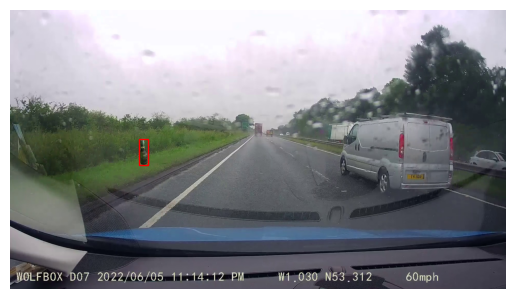

In [116]:
import matplotlib.patches as patches

#get cropped taco image and mask
im, mask = getTaco(taco_path,0)

verge = getVerge(r"C:\Users\oakle\OneDrive - University of Lincoln\MSc Intelligent Vision\Project\segmentation\seg_dataset\gv_seg\20220605231413_000097_Trim_frame2.jpg")


new_lit_height = 100
#resize litter to height 100
context_cut, w , h = image_resize(im,height=new_lit_height) ; context_mask,_,_ = image_resize(mask,height=new_lit_height)

locx = 500
locy = 500

#combine with background
merged, _ , _ = combine(context_cut, context_mask, verge, locx , locy)

rect = patches.Rectangle((locx, locy), w, h, linewidth=1, edgecolor='r', facecolor='none')

fig, ax = plt.subplots()

ax.add_patch(rect)

plt.axis('off')
plt.imshow(merged)


loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
1689 370
(1080, 1920, 3)
bk: (100, 33, 3)


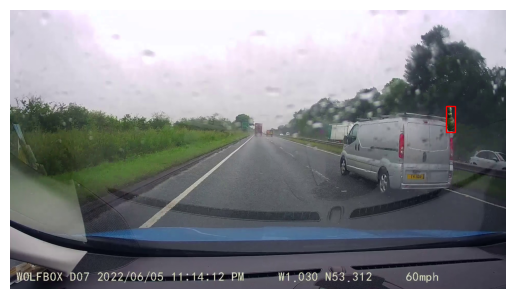

In [165]:
#random placement
import random

#get height & width of verge
vh = verge.shape[0]; vw = verge.shape[1]
#placement x must be between (0: vh- litter height)
#placement y must be between (0: vw- litter width)

#get cropped taco image and mask
im, mask = getTaco(taco_path,0)

verge = getVerge(r"C:\Users\oakle\OneDrive - University of Lincoln\MSc Intelligent Vision\Project\segmentation\seg_dataset\gv_seg\20220605231413_000097_Trim_frame2.jpg")


new_lit_height = 100

#resize litter to height 100
context_cut, w , h = image_resize(im,height=new_lit_height) ; context_mask,_,_ = image_resize(mask,height=new_lit_height)

locx = random.randint(0, vw-w) #170#random.randint(0, vh-h)
locy = random.randint(0, vh-h)#1505 #random.randint(0, vw-w)

print(locx,locy)
print(verge.shape)

#combine with background
merged, _ , _ = combine(context_cut, context_mask, verge, locx , locy)

rect = patches.Rectangle((locx, locy), w, h, linewidth=1, edgecolor='r', facecolor='none')

fig, ax = plt.subplots()

ax.add_patch(rect)

plt.axis('off')
plt.imshow(merged)
